# YASA

Channels:
- EEG(Fpz-Cz)  
- EOG(horizontal)  
- EMG(submental)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yasa
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
from sklearn.metrics import accuracy_score

In [2]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

### データの事前処理

In [3]:
# ここのsubjectsの中の数字を変えることで、対象データを変更
#  3 -> SC4031E0-PSG.edf
# 21 -> SC4211E0-PSG.edf
[subject] = fetch_data(subjects=[14], recording=[1])

edf = mne.io.read_raw_edf(subject[0],
                          stim_channel='Event marker',
                          misc=['Temp rectal'])

annot = mne.read_annotations(subject[1])

annot.crop(annot[1]['onset'] - 30 * 60,
           annot[-2]['onset'] + 30 * 60)

edf.set_annotations(annot, emit_warning=False)

events, _ = mne.events_from_annotations(edf,
                                        event_id=annotation_desc_2_event_id,
                                        chunk_duration=30.)

tmax = 30. - 1. / edf.info['sfreq']

epochs = mne.Epochs(raw=edf,
                    events=events,
                    event_id=event_id,
                    tmin=0.,
                    tmax=tmax,
                    baseline=None)

# 1次元配列の抽出
hypno = epochs.events[:, 2] - 1

edf.crop(annot[1]['onset'] - 30 * 60,
         annot[-2]['onset'] + 40 * 60)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4141E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1004 matching events found
No baseline correction applied
0 projection items activated


<RawEDF | SC4141E0-PSG.edf, 7 x 3069001 (30690.0 s), ~12 kB, data not loaded>

### 睡眠ステージの推定

In [4]:
sls = yasa.SleepStaging(edf, eeg_name="EEG Fpz-Cz", eog_name="EOG horizontal", emg_name="EMG submental")
hypno_pred = sls.predict()
hypno_pred = yasa.hypno_str_to_int(hypno_pred)

### 特徴量の表示

In [5]:
model = sls._load_model("auto")
print(model.feature_name_)

eeg, eog, emg = 0, 0, 0
c = 0
for data in model.feature_name_:
    if "eeg" in data:
        eeg += 1
    elif "eog" in data:
        eog += 1
    elif "emg" in data:
        emg += 1
    else:
        print(data)
    c += 1

print(eeg, eog, emg)
print(eeg+eog+emg, c)

['eeg_abspow', 'eeg_abspow_c7min_norm', 'eeg_abspow_p2min_norm', 'eeg_alpha', 'eeg_alpha_c7min_norm', 'eeg_alpha_p2min_norm', 'eeg_at', 'eeg_at_c7min_norm', 'eeg_at_p2min_norm', 'eeg_beta', 'eeg_beta_c7min_norm', 'eeg_beta_p2min_norm', 'eeg_db', 'eeg_db_c7min_norm', 'eeg_db_p2min_norm', 'eeg_ds', 'eeg_ds_c7min_norm', 'eeg_ds_p2min_norm', 'eeg_dt', 'eeg_dt_c7min_norm', 'eeg_dt_p2min_norm', 'eeg_fdelta', 'eeg_fdelta_c7min_norm', 'eeg_fdelta_p2min_norm', 'eeg_hcomp', 'eeg_hcomp_c7min_norm', 'eeg_hcomp_p2min_norm', 'eeg_higuchi', 'eeg_higuchi_c7min_norm', 'eeg_higuchi_p2min_norm', 'eeg_hmob', 'eeg_hmob_c7min_norm', 'eeg_hmob_p2min_norm', 'eeg_iqr', 'eeg_iqr_c7min_norm', 'eeg_iqr_p2min_norm', 'eeg_kurt', 'eeg_kurt_c7min_norm', 'eeg_kurt_p2min_norm', 'eeg_nzc', 'eeg_nzc_c7min_norm', 'eeg_nzc_p2min_norm', 'eeg_perm', 'eeg_perm_c7min_norm', 'eeg_perm_p2min_norm', 'eeg_petrosian', 'eeg_petrosian_c7min_norm', 'eeg_petrosian_p2min_norm', 'eeg_sdelta', 'eeg_sdelta_c7min_norm', 'eeg_sdelta_p2min_no

### ヒプノグラムの表示

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

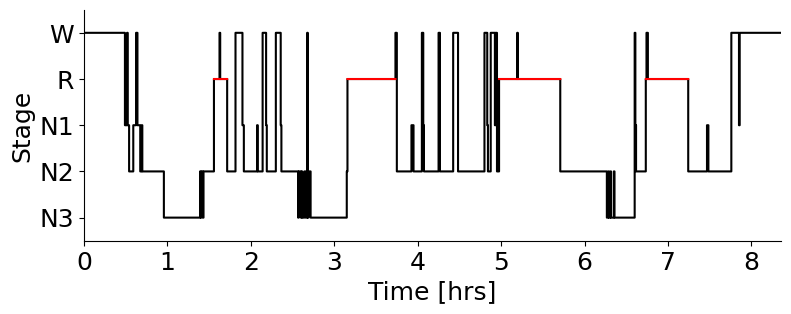

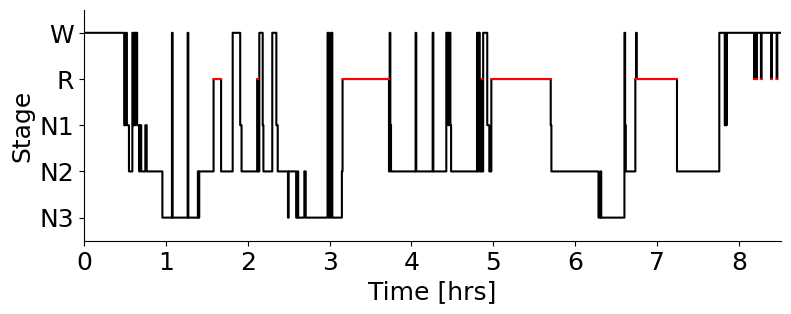

In [6]:
yasa.plot_hypnogram(hypno)
yasa.plot_hypnogram(hypno_pred)

### 正解率の算出

In [7]:
length = -(len(hypno_pred) - len(hypno))
acc = accuracy_score(hypno, hypno_pred[:length]) # 正解率

print('正解率: ', acc)

正解率:  0.9342629482071713
